In [84]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx
from pathlib import Path
import subprocess

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.utils import add_features
from src.data.continents_clusters import regions

In [85]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

In [86]:
# df_movies has duplicates of the same movies which will be discarded based on keeping  
# the entry that has the least number of missing values among the other columns. Only 
# duplicate movies with equal countries are kept
df_movies = cleaning.drop_most_missing(df_movies, ['title', 'countries'])

In [87]:
# doing the same duplicates cleaning as before for df_tmdb, considering 
# 'production_countries' instead of 'countries'
df_tmdb = cleaning.drop_most_missing(df_tmdb, ['title', 'production_countries'])

In [88]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [89]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [90]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [91]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [92]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [93]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [94]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Text(0, 0.5, 'Count of Ratings')

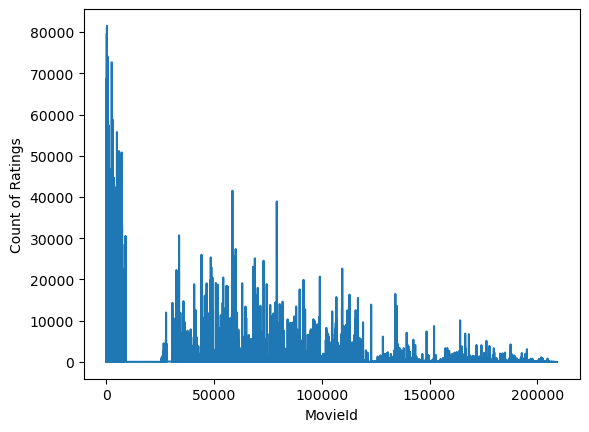

In [95]:
# testing how many ratings each movie has
ratings_distirbution = df_ratings_ratings.groupby("movieId").count()
ratings_distirbution = ratings_distirbution.reset_index()
plt.plot(ratings_distirbution["movieId"], ratings_distirbution["userId"])
plt.xlabel("MovieId")
plt.ylabel("Count of Ratings")

In [96]:
# filtering for movies with over 10 ratings
ratings_count = df_ratings_ratings.groupby("movieId")["rating"].count()
movies_with_10_plus_ratings = ratings_count[ratings_count > 10].index
filtered_ratings = df_ratings_ratings[df_ratings_ratings["movieId"].isin(movies_with_10_plus_ratings)].copy()

# taking the mean of each movie's rating
mean_ratings = filtered_ratings.groupby("movieId").mean()

# making the mean of each movie's rating an increment of 0.5
# mean_ratings["rating"] = filtered_ratings["rating"].apply(lambda x: round(x*2)/2)
mean_ratings = mean_ratings.reset_index()

In [97]:
# further cleaning of the ratings dataset is required before merging to the movies metadata
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_tmdb_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 14073 unique movies in our movies dataset that have ratings given by the found dataset.


In [98]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [99]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

In [100]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones -> Jake added, below, cleaning of the genres to avoid redundancy
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# making every genre's text uniform to assess unique genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.lower()

# removing redundant verbiage for genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" movies", "")

# fixing some genres being as lists
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].map(str)
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("[", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("]", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("'", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace('"', "")

In [101]:
# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [102]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones -> Jake added further cleaning of genres before choosing the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.lower()

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].map(str)
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("[", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("]", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("'", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace('"', "")

df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# cleaning the single genre movies' genres
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.lower()

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" film", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("[", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("]", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("'", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace('"', "")

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

# converting 'genres' column type
df_movies_tmdb_ratings['genres'] = df_movies_tmdb_ratings['genres'].astype(str)

The mean number of countries of a given movie is:  2


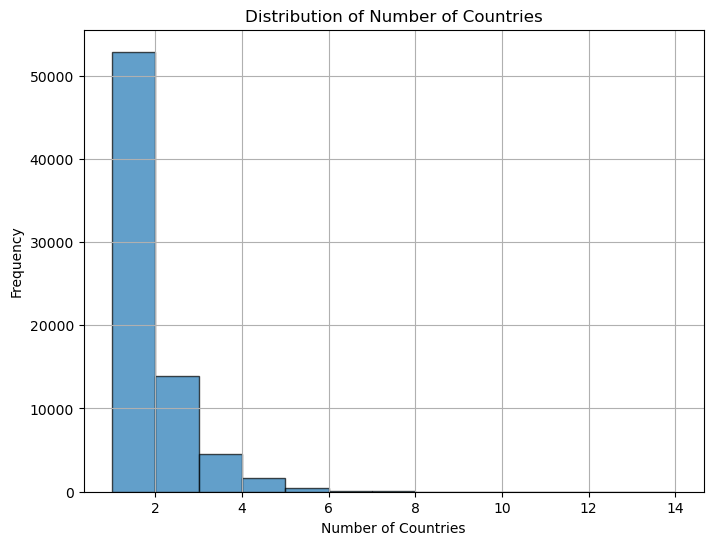

In [103]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

# getting the mean
print(f'The mean number of countries of a given movie is: ', math.ceil(df_movies_tmdb_ratings['countries'].apply(len).mean()))

# plotting the distribution
n_countries = df_movies_tmdb_ratings['countries'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_countries, bins=range(1, max(n_countries) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Countries')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')
plt.grid(True)

In [104]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [105]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [106]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

In [107]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 13889 unique movies in the standard movies dataset.
There were 79347 unique movies in the initial movies dataset.


In [108]:
# deleting not used dataframes (but keeping the original ones)
del df_movies_tmdb
del df_movies_tmdb_ratings_exploded
del df_movies_tmdb_ratings_multi
del df_ratings_linked

# Historical Proximity Score

The dataframe must be filled manually. Entries are in range from -1 to 1. 
Taking into account that a movie takes minimum a year to produce (in general), if a meaningful historical event happens, a score of 1 is given to the exact year of the event and the year later, then the score lowers by 0.2 each year. Therefore, an historical event has a decreasing impact on movies for the next 5 years. If the event is positive, the score is positive, viceversa if the event is negative. Events for each country are asked to ChatGPT.

In [109]:
# saving df_movies_tmdb_ratings as a pickle file
output_path = Path("src/scripts/df_movies_tmdb_ratings.pkl")
df_movies_tmdb_ratings.to_pickle(output_path)

# running historical_proximity.py script
result = subprocess.run(["python", "src/scripts/historical_proximity.py"], capture_output=True, text=True)

# if the script failed, print the error message
if result.returncode != 0:
    print("Error occurred:")
    print(result.stderr)
else:
    print("Script ran successfully.")

# loading historical_proximity_score
historical_proximity_score = pd.read_pickle("src/scripts/historical_proximity_score.pkl")

Script ran successfully.


In [110]:
# checking if there are any rows with only zeros
rows_with_zeros = historical_proximity_score.loc[(historical_proximity_score == 0).all(axis=1)]

if not rows_with_zeros.empty:
    print("There are rows with only zeros.")
else:
    print("No rows with only zeros.")

No rows with only zeros.


In [111]:
# adding historical_proximity_score column
df_movies_tmdb_ratings['historical_proximity_score'] = df_movies_tmdb_ratings.apply(
    lambda row: add_features.get_historical_proximity_score(row, historical_proximity_score), axis=1
)

Adding genre complexity score

In [112]:
# defining unique_genres_per_movie series
unique_genres_per_movie = (
    df_movies_tmdb_ratings.explode('genres') 
    .groupby('title')['genres'].nunique()
)

# get_genre_complexity_score() call
complexity_dict = add_features.get_genre_complexity_score(unique_genres_per_movie)

# new dataframe column
df_movies_tmdb_ratings['genre_complexity_score'] = df_movies_tmdb_ratings['title'].map(complexity_dict)

# Additional pre-processing

Before proceeding with the decision tree model, the region column will be added to the dataframe.

In [113]:
# map_regions() call
country_to_region = add_features.map_regions(regions)

# mapping the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped.
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

In [114]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

In [115]:
# keeping top 20 clean genres for the decision tree model
genres_total = df_movies_tmdb_ratings.groupby("genres").count().sort_values("wikipedia_id", ascending=False).reset_index()

# extracting top 20 genres
top_20_genres = genres_total.loc[:19, "genres"]

# defining new top 20 genres dataframe
df_movies_tmdb_ratings_top20genres = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"].isin(top_20_genres)]

# resetting indexes
df_movies_tmdb_ratings_top20genres = df_movies_tmdb_ratings_top20genres.reset_index(drop=True)

In [116]:
# Binning mean ratings
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]

# Creating new column with .loc to avoid SettingWithCopyWarning
df_movies_tmdb_ratings_top20genres.loc[:, 'binned_rating'] = pd.cut(
    df_movies_tmdb_ratings_top20genres['mean_rating'],
    bins=bins,
    labels=labels,
    right=False
)

# Decision Tree Model

In [117]:
from sklearn.preprocessing import LabelEncoder

# aggregating repeated movies to consider only mode of features (to avoid potential bias)
data = df_movies_tmdb_ratings_top20genres.groupby('title').agg({
    'release_date': lambda x: x.mode()[0],
    'revenue': 'mean',
    'runtime': 'mean',
    'genres': lambda x: x.mode()[0],
    'budget': 'mean',
    'historical_proximity_score': 'mean',
    'genre_complexity_score': 'mean',
    'region': lambda x: x.mode()[0],
    'binned_rating': lambda x: x.mode()[0]
}).reset_index()

# keeping only some features and specifing the target variable
features = df_movies_tmdb_ratings_top20genres[
    [
        'release_date',
        'revenue',
        'runtime',
        'genres',
        'budget',
        'historical_proximity_score',
        'genre_complexity_score',
        'region',
    ]
]

target = df_movies_tmdb_ratings_top20genres[['binned_rating']]

# encoding target variable to discrete classes
encoder = LabelEncoder()
target = encoder.fit_transform(target)

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [118]:
# one-hot encoding of some features (no dropping of the first column)
features = pd.get_dummies(features, columns=['genres', 'region'], drop_first=True)
#features = pd.get_dummies(features, columns=['region'], drop_first=True)
#features = pd.get_dummies(features, columns=['genres'], drop_first=True)

In [ ]:
from sklearn.model_selection import train_test_split

# train-test split 80-20 ratio
df_train, df_test, df_train_target, df_test_target = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# The final number of values in the resulting training and testing dataframes is required
print(f'The number of samples in the train dataset is: {len(df_train)}')
print(f'The number of samples in the test dataset is: {len(df_test)}')

The number of samples in the train dataset is: 63460
The number of samples in the test dataset is: 7052


In [120]:
from sklearn.tree import DecisionTreeClassifier

# DecisionTreeClassifier call
decision_tree = DecisionTreeClassifier(random_state=42).fit(df_train, df_train_target)

In [121]:
# predicting test set
target_predict = decision_tree.predict(df_test)

# printing depth of the tree
D = decision_tree.get_depth()
print(f'The depth of the decision tree is: {D}')

The depth of the decision tree is: 48


In [122]:
from sklearn.metrics import classification_report

# evaluating metrics
print(classification_report(df_test_target, target_predict))

              precision    recall  f1-score   support

           1       0.57      0.57      0.57         7
           2       0.76      0.78      0.77        85
           3       0.80      0.78      0.79       425
           4       0.84      0.85      0.84      1451
           5       0.89      0.90      0.89      2861
           6       0.89      0.88      0.88      2100
           7       0.88      0.87      0.88       123

    accuracy                           0.87      7052
   macro avg       0.80      0.80      0.80      7052
weighted avg       0.87      0.87      0.87      7052



The best depth in terms of accuracy is: 42


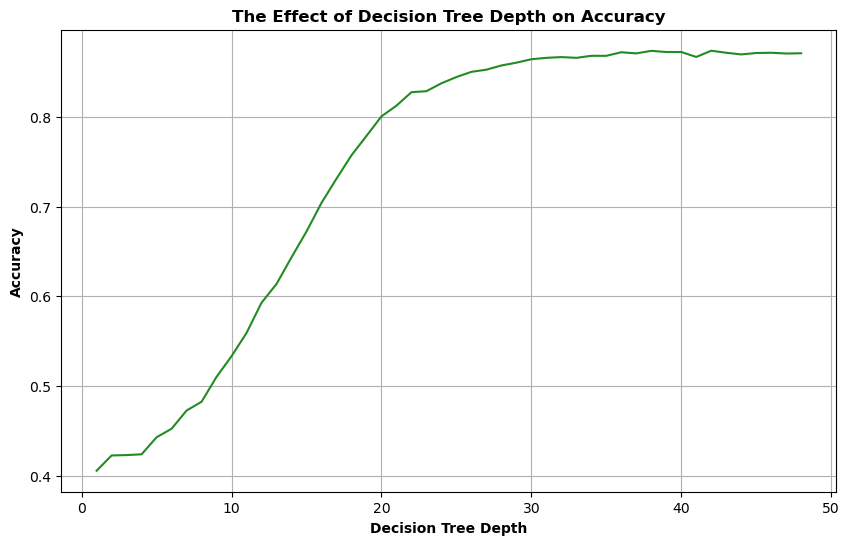

In [123]:
from sklearn.metrics import accuracy_score

# searching D that maximizes accuracy of the model
accuracies = np.zeros(D)

for d in range(0, D):
    decision_tree = DecisionTreeClassifier(max_depth=d+1, random_state=42).fit(df_train, df_train_target)

    # predicting outcomes
    target_predict = decision_tree.predict(df_test)
    accuracies[d] = accuracy_score(df_test_target, target_predict)

# plotting results
plt.figure(figsize=(10, 6))
plt.plot(range(1, D+1), accuracies,  '-', color='forestgreen')
plt.xlabel('Decision Tree Depth',  weight='bold')
plt.ylabel('Accuracy',  weight='bold')
plt.title('The Effect of Decision Tree Depth on Accuracy', weight='bold')
plt.grid(True)

# getting best tree depth
best_acc = np.max(accuracies)
best_d = np.where(accuracies == best_acc)[0]

print(f'The best depth in terms of accuracy is: {best_d[0]+1}')

In [124]:
from sklearn.ensemble import RandomForestClassifier

# train-test split 80-20 ratio
df_train, df_test, df_train_target, df_test_target = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# The final number of values in the resulting training and testing dataframes is required
print(f'The number of samples in the train dataset is: {len(df_train)}')
print(f'The number of samples in the test dataset is: {len(df_test)}')

# Create the model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest.fit(df_train, df_train_target)

# prediction
target_predict = random_forest.predict(df_test)

# Accuracy
accuracy = accuracy_score(df_test_target, target_predict)
print(f"Accuracy: {accuracy}")

The number of samples in the train dataset is: 56409
The number of samples in the test dataset is: 14103
Accuracy: 0.772317946536198
